In [3]:
import os, sys
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)
project_root

'/Users/richa/bill-s-coldest-game-ev'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.models.ev_calculator import american_odds_to_prob, expected_value

df = pd.read_csv("../data/processed/highmark_daily_min_2024_2025_example.csv", parse_dates=["date"])
df.head()

,date,min_temp_c
0,2024-12-01,-3.1
1,2024-12-02,-5.2
2,2024-12-03,-5.2
3,2024-12-04,-4.3
4,2024-12-05,-3.9


In [5]:
df["day_of_year"] = df["date"].dt.dayofyear
df["month"] = df["date"].dt.month
df.describe()

,date,min_temp_c,day_of_year,month
count,90,90.000000,90.000000,90.000000
mean,2025-01-14 12:00:00,-5.716667,140.566667,5.100000
min,2024-12-01 00:00:00,-17.600000,1.000000,1.000000
25%,2024-12-23 06:00:00,-9.150000,23.250000,1.000000
50%,2025-01-14 12:00:00,-5.900000,45.500000,2.000000
75%,2025-02-05 18:00:00,-2.450000,343.750000,12.000000
max,2025-02-28 00:00:00,5.500000,366.000000,12.000000
std,NaN,4.841377,154.105323,5.045968


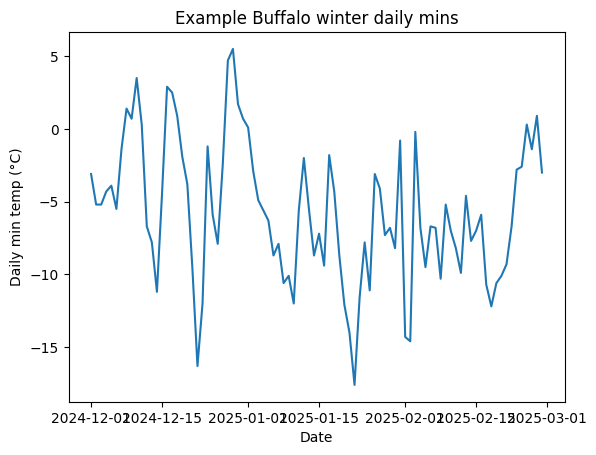

In [6]:
plt.figure()
plt.plot(df["date"], df["min_temp_c"])
plt.xlabel("Date")
plt.ylabel("Daily min temp (°C)")
plt.title("Example Buffalo winter daily mins")
plt.show()

In [7]:
monthly_stats = df.groupby("month")["min_temp_c"].agg(["mean", "std"])
monthly_stats

,mean,std
month,,
1,-7.309677,4.029504
2,-6.889286,4.143477
12,-3.064516,5.164594


In [8]:
import datetime as dt

def sample_min_temp_for_date(date: dt.date, rng: np.random.Generator) -> float:
    month = date.month
    mu = monthly_stats.loc[month, "mean"]
    sigma = monthly_stats.loc[month, "std"]
    return rng.normal(mu, sigma)

In [11]:
example_home_dates = [
    dt.date(2024, 12, 8),
    dt.date(2024, 12, 22),
    dt.date(2025, 1, 5),
    dt.date(2025, 1, 19),
    dt.date(2025, 2, 2),
    dt.date(2025, 2, 16),
    dt.date(2025, 2, 23),
]

example_home_dates


[datetime.date(2024, 12, 8),
 datetime.date(2024, 12, 22),
 datetime.date(2025, 1, 5),
 datetime.date(2025, 1, 19),
 datetime.date(2025, 2, 2),
 datetime.date(2025, 2, 16),
 datetime.date(2025, 2, 23)]

In [12]:
rng = np.random.default_rng(seed=42)

n_seasons = 50000
season_minima = []

for _ in range(n_seasons):
    temps = [sample_min_temp_for_date(d, rng) for d in example_home_dates]
    season_minima.append(min(temps))

season_minima = np.array(season_minima)
season_minima.mean(), season_minima.min(), season_minima.max()

(np.float64(-12.150640554820336),
 np.float64(-27.1680345430285),
 np.float64(-3.5121068126889607))

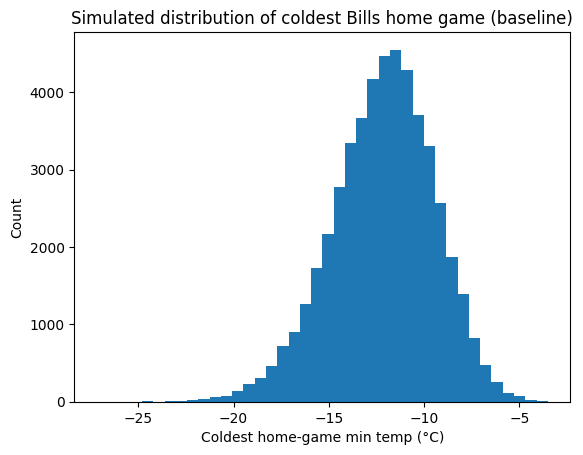

In [13]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(season_minima, bins=40)
plt.xlabel("Coldest home-game min temp (°C)")
plt.ylabel("Count")
plt.title("Simulated distribution of coldest Bills home game (baseline)")
plt.show()

In [21]:
bins = {
    "0C_or_warmer": (0, np.inf),           # >= 0
    "minus1_to_minus5": (-5, 0),           # [-5, 0)
    "minus6_to_minus10": (-10, -5),        # [-10, -5)
    "minus11_to_minus15": (-15, -10),      # [-15, -10)
    "minus15_to_minus20": (-20, -15),      # [-20, -15)
    "minus21_or_colder": (-np.inf, -20),   # < -20
}

In [23]:
def estimate_bin_probs(minima: np.ndarray, bins: dict) -> dict:
    probs = {}
    for name, (low, high) in bins.items():
        if np.isneginf(low):
            mask = minima <= high
        elif np.isposinf(high):
            mask = minima >= low
        else:
            mask = (minima >= low) & (minima <= high)
        probs[name] = mask.mean()
    return probs

bin_probs = estimate_bin_probs(season_minima, bins)
bin_probs

{'0C_or_warmer': np.float64(0.0),
 'minus1_to_minus5': np.float64(0.00096),
 'minus6_to_minus10': np.float64(0.21484),
 'minus11_to_minus15': np.float64(0.64082),
 'minus15_to_minus20': np.float64(0.13872),
 'minus21_or_colder': np.float64(0.00466)}

In [20]:
from src.models.ev_calculator import american_odds_to_prob, expected_value
import pandas as pd

fanduel_odds = {
    "0C_or_warmer": 2000,
    "minus1_to_minus5": 550,
    "minus6_to_minus10": 210,
    "minus11_to_minus15": 150,
    "minus15_to_minus20": 430,
    "minus21_or_colder": 750,
}

rows = []
for bucket, o in fanduel_odds.items():
    p_true = bin_probs.get(bucket, 0.0)
    implied = american_odds_to_prob(o)
    ev_1 = expected_value(p_true, o, stake=1.0)
    rows.append(
        {
            "bucket": bucket,
            "odds": o,
            "implied_prob": implied,
            "model_prob": p_true,
            "EV_per_$1": ev_1,
        }
    )

ev_df = pd.DataFrame(rows).sort_values("EV_per_$1", ascending=False)
ev_df

,bucket,odds,implied_prob,model_prob,EV_per_$1
3,minus11_to_minus15,150,0.400000,0.64082,0.602050
4,minus15_to_minus20,430,0.188679,0.13872,-0.264784
2,minus6_to_minus10,210,0.322581,0.21484,-0.333996
5,minus21_or_colder,750,0.117647,0.00466,-0.960390
1,minus1_to_minus5,550,0.153846,0.00096,-0.993760
0,0C_or_warmer,2000,0.047619,0.00000,-1.000000
